### Initialize

In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from adjustText import adjust_text
from scipy.sparse import coo_matrix
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader

import pygini

random.seed(42)
torch.manual_seed(42)
torch.mps.manual_seed(42)

In [2]:
chr_index = pd.read_csv("index.csv", header=0)
pos_coord_egfr = np.where(chr_index["loc"] == "chr7_55000000")[0][0]
pos_coord_myc = np.where(chr_index["loc"] == "chr8_127000000")[0][0]

window_0 = 5
window_1 = 5

chr_size = [249, 243, 199, 191, 182, 171, 160, 146, 139, 134, 136, 134, 115, 108, 102, 91, 84, 81, 59, 65, 47, 51, 157]

In [3]:
def read_mtx(path, index):
    contact_mat = pd.read_csv(path, sep="\t", header=0)
    contact_mat = contact_mat[(contact_mat["chrom1"] != "chrY") & (contact_mat["chrom2"] != "chrY")]
    contact_mat = pd.concat([contact_mat["chrom1"] + "_" + contact_mat["start1"].astype(str),
                             contact_mat["chrom2"] + "_" + contact_mat["start2"].astype(str), contact_mat["count"]],
                            axis=1)
    contact_mat.columns = ["loc1", "loc2", "count"]
    contact_mat = pd.merge(contact_mat, index, left_on="loc1", right_on="loc", how="left").drop(["loc", "loc1"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index1"})
    contact_mat = pd.merge(contact_mat, index, left_on="loc2", right_on="loc", how="left").drop(["loc", "loc2"], axis=1)
    contact_mat = contact_mat.rename(columns={contact_mat.columns[2]: "index2"})
    contact_mat = coo_matrix((contact_mat['count'], (contact_mat['index1'], contact_mat['index2'])),
                             shape=(index.shape[0], index.shape[0]))
    contact_mat = contact_mat.toarray()

    return contact_mat

In [4]:
def prep_data(sample, coord, index, is_pos, win0):
    matrices_f2 = []
    bcs = []

    directories = sorted(
        [d for d in os.listdir("data/raw/" + sample) if os.path.isdir(os.path.join("data/raw/" + sample, d))])
    for directory in directories:

        if not os.path.exists("data/raw/" + sample + "/" + directory + "/1000000.CNV.bedGraph"):
            continue

        try:
            mtx = read_mtx("data/raw/" + sample + "/" + directory + "/matrix.mtx", index)
        except:
            continue

        mtx_f2 = mtx[(coord - int((win0 + 1) / 2) + 1):(coord + int((win0 + 1) / 2)), :]

        stacked_mtx_f2 = torch.from_numpy(mtx_f2).to_sparse_coo()

        matrices_f2.append(stacked_mtx_f2)
        bcs = bcs + [directory]

    input = torch.stack(matrices_f2, dim=0)

    if is_pos:
        label = torch.from_numpy(np.ones(input.shape[0])).int()
    else:
        label = torch.from_numpy(np.zeros(input.shape[0])).int()

    return input, label, bcs

### Prepare data

In [5]:
orig_index = pd.read_csv("data/raw/LC675/LC675_TTTGGTTGTTGGCGAA/1000000.CNV.bedGraph", sep="\t", header=None).iloc[:,0:3]

orig_index.columns = ["chrom", "start", "end"]
orig_index = orig_index[orig_index["chrom"] != "chrY"]
orig_index = orig_index["chrom"] + "_" + orig_index["start"].astype(str)
orig_index = pd.concat([orig_index, pd.DataFrame(np.arange(orig_index.shape[0]))], axis=1)
orig_index.columns = ["loc", "index"]

orig_index.to_csv("index.csv", index=False)

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC499", pos_coord_egfr, chr_index, True, window_0)
neg_data, neg_label, neg_bcs = prep_data("LC500", pos_coord_egfr, chr_index, False, window_0)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_499500.npy")
torch.save(label, "data/processed/label_499500.npy")
torch.save(barcode, "data/processed/barcodes_499500.npy")

In [ ]:
val_split = 0.1

len_indices = len(input_all)
all_indices = list(range(len_indices))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indices))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_train = torch.index_select(input_all, 0, train_indices)
label_train = torch.index_select(label, 0, train_indices)
bcs_train = [barcode[i] for i in train_indices]

input_val = torch.index_select(input_all, 0, val_indices)
label_val = torch.index_select(label, 0, val_indices)
bcs_val = [barcode[i] for i in val_indices]

pd.DataFrame(bcs_val).to_csv("data/processed/barcode_val_499500.txt", index=False, header=False)

In [ ]:
pos_data, pos_label, pos_bcs = prep_data("LC676", pos_coord_myc, chr_index, True, window_0)
neg_data, neg_label, neg_bcs = prep_data("LC677", pos_coord_myc, chr_index, False, window_0)

input_all = torch.cat((pos_data, neg_data), dim=0).unsqueeze(1)
label = torch.cat((pos_label, neg_label), dim=0)
barcode = pos_bcs + neg_bcs

In [ ]:
torch.save(input_all, "data/processed/input_676677.npy")
torch.save(label, "data/processed/label_676677.npy")
torch.save(barcode, "data/processed/barcode_676677.npy")

In [ ]:
val_split = 0.1

len_indices = len(input_all)
all_indices = list(range(len_indices))
random.shuffle(all_indices)
num_val = int(np.floor(val_split * len_indices))

val_indices = torch.tensor(all_indices[:num_val])
train_indices = torch.tensor(all_indices[num_val:])

input_train = torch.index_select(input_all, 0, train_indices)
label_train = torch.index_select(label, 0, train_indices)
bcs_train = [barcode[i] for i in train_indices]

input_val = torch.index_select(input_all, 0, val_indices)
label_val = torch.index_select(label, 0, val_indices)
bcs_val = [barcode[i] for i in val_indices]

pd.DataFrame(bcs_val).to_csv("data/processed/barcode_val_676677.txt", index=False, header=False)

### Define model

In [5]:
input_499500 = torch.load("data/processed/input_499500.npy").to_dense()
label_499500 = torch.load("data/processed/label_499500.npy")
barcode_499500 = torch.load("data/processed/barcode_499500.npy")

input_676677 = torch.load("data/processed/input_676677.npy").to_dense()
label_676677 = torch.load("data/processed/label_676677.npy")
barcode_676677 = torch.load("data/processed/barcode_676677.npy")

In [6]:
coordinate_499500 = np.repeat(pos_coord_egfr, input_499500.shape[0]).tolist()
coordinate_676677 = np.repeat(pos_coord_myc, input_676677.shape[0]).tolist()

In [7]:
label_676677 = torch.where(label_676677 == 0, 2, label_676677) # Mark HSR samples as 2

In [ ]:
# Use this block for ecDNA evaluation

#input_all = input_499500
#label = label_499500
#barcode = barcode_499500
#coordinate = coordinate_499500

In [8]:
barcode = barcode_499500 + barcode_676677
coordinate = coordinate_499500 + coordinate_676677

input_all = torch.cat((input_499500, input_676677), dim=0)
label = torch.cat((label_499500, label_676677), dim=0)

In [9]:
validation_bcs_499500 = pd.read_table("data/processed/barcode_val_499500.txt", header=None).iloc[:, 0].tolist()
validation_bcs_676677 = pd.read_table("data/processed/barcode_val_676677.txt",header=None).iloc[:,0].tolist()
validation_bcs = validation_bcs_499500 + validation_bcs_676677

validation_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] in validation_bcs])
training_indices = torch.tensor([i for i in range(len(barcode)) if barcode[i] not in validation_bcs])

In [10]:
input_train = torch.index_select(input_all, 0, training_indices)
label_train = torch.index_select(label, 0, training_indices)
barcode_train = [barcode[i] for i in training_indices]
coordinate_train = [coordinate[i] for i in training_indices]

input_val = torch.index_select(input_all, 0, validation_indices)
label_val = torch.index_select(label, 0, validation_indices)
barcode_val = [barcode[i] for i in validation_indices]
coordinate_val = [coordinate[i] for i in validation_indices]

In [11]:
class QuadDataset(Dataset):
    def __init__(self, input, label, barcode, coord):
        self.input = input
        self.label = label
        self.barcode = barcode
        self.coord = coord

    def __len__(self):
        return len(self.input)

    def __getitem__(self, index):
        input_s = self.input[index]
        bc_s = self.barcode[index]
        coord_s = self.coord[index]
        
        label_s = torch.eye(3)[self.label[index].detach().numpy()] # Negative, ecDNA, HSR

        return input_s, label_s, bc_s, coord_s

In [12]:
batch_size = 32

train_dataloader = DataLoader(QuadDataset(input_train, label_train, barcode_train, coordinate_train), batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(QuadDataset(input_val, label_val, barcode_val, coordinate_val), batch_size=batch_size, shuffle=False)
#test_dataloader1 = DataLoader(QuadDataset(input_676677, label_676677, barcode_676677, coordinate_676677), batch_size=batch_size, shuffle=False)
#test_dataloader2 = DataLoader(QuadDataset(input_729730, label_729730, barcode_729730, coordinate_729730), batch_size=batch_size, shuffle=False)

In [13]:
def zi_pois_noise(shape, lambda_, p_zero):
    uniform_noise = torch.rand(shape)

    zero_mask = uniform_noise < p_zero

    poisson_noise = torch.poisson(lambda_ * torch.ones(shape))

    noise = poisson_noise * ~zero_mask

    return noise

In [14]:
class BootCELoss(nn.Module):
    def __init__(self, alpha, bootstrap_type, pos_weight):
        super(BootCELoss, self).__init__()
        self.alpha = alpha
        self.bootstrap_type = bootstrap_type
        self.pos_weight = pos_weight

    def forward(self, prediction_tensor, target_tensor):
        if self.bootstrap_type == 'soft':
            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * prediction_tensor
            
        elif self.bootstrap_type == 'hard':
            max_index = torch.argmax(prediction_tensor, dim=1)
            prediction_tensor_binary = torch.zeros_like(prediction_tensor)
            prediction_tensor_binary[max_index] = 1
            
            bootstrap_target_tensor = self.alpha * target_tensor + (1.0 - self.alpha) * (prediction_tensor_binary).float()
        else:
            raise ValueError('Not a valid value of bootstrap_type')

        per_entry_cross_ent = F.cross_entropy(input=prediction_tensor,
                                                                 target=bootstrap_target_tensor, reduction='mean',
                                                                 weight=torch.Tensor(self.pos_weight).to("mps"))

        return per_entry_cross_ent

In [15]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_f2_l1 = nn.Conv2d(1, 8, kernel_size=(5, 45), stride=(1, 11), padding=(0, 2))
        self.conv_f2_l2 = nn.Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4), padding=(0, 0))

        self.bn_f2_l1 = nn.BatchNorm2d(8)
        self.bn_f2_l2 = nn.BatchNorm2d(16)

        self.bn_fc_l1 = nn.BatchNorm1d(64)

        self.pool_f2_l1 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)
        self.pool_f2_l2 = nn.MaxPool2d(kernel_size=(1, 2), stride=2, padding=0)

        self.fc_l1 = nn.Linear(5 * 5 + 12 * 16 + 5 + 1, 64)
        self.fc_l2 = nn.Linear(64, 3)

        #self.dropout_f1 = nn.Dropout(0.5)
        self.dropout_f2 = nn.Dropout(0.5)

        self.dropout_fc = nn.Dropout(0.5)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x2, coord):
        #if self.training:
        #    noise = zi_pois_noise(x2.shape, 1, 0.9999)  # test this
        #    x2 = x2 + noise.float().to("mps")

        start_indices = coord - int((5 + 1) / 2) + 1
        end_indices = coord + int((5 + 1) / 2)
        
        x2_chr = torch.split(x2[...,2,:], chr_size, dim=-1)
        x2_c = torch.stack([torch.squeeze(torch.sum(st, dim=-1), dim=-1) for st in x2_chr], dim=-1)
        
        #chr = F.normalize(x2_c, dim=-1, p=1)
        
        gini = []
        for i in range(x2_c.shape[0]):
            gini.append(torch.tensor(pygini.gini(x2_c[i, :].cpu().numpy()),dtype=torch.float32))
        gini = torch.unsqueeze(torch.stack(gini, dim=0).to("mps"), dim=-1)
        
        d4_slices = []

        for i in range(x2.size(0)):
            d4_slices.append(x2[i, ..., start_indices[i]:end_indices[i]])

        x1 = torch.stack(d4_slices, dim=0)

        x1 = (x1 > 0).float()
        x2 = (x2 > 0).float()

        x2_s = F.normalize(torch.squeeze(torch.sum(x2, dim=-1), dim=1), dim=-1, p=1)

        x2 = self.pool_f2_l1(F.relu(self.bn_f2_l1(self.conv_f2_l1(x2))))
        x2 = self.dropout_f2(x2)
        x2 = self.pool_f2_l2(F.relu(self.bn_f2_l2(self.conv_f2_l2(x2))))

        x1 = x1.view(-1, 5 * 5)
        x2 = x2.view(-1, 12 * 16)

        #x = torch.cat((torch.zeros_like(x1), x2, x2_s, gini), dim=1)
        #x = torch.cat((x1, torch.zeros_like(x2), x2_s, gini), dim=1)
        #x = torch.cat((x1, x2, torch.zeros_like(x2_s), gini), dim=1)
        #x = torch.cat((x1, x2, x2_s, torch.zeros_like(gini)), dim=1)
        
        x = torch.cat((x1, x2, x2_s, gini), dim=1)

        x = self.dropout_fc(F.gelu(self.bn_fc_l1(self.fc_l1(x))))

        x = self.softmax(self.fc_l2(x))

        return x

In [17]:
model = CNN().to("mps")

criterion = BootCELoss(alpha=0.99, bootstrap_type="hard", pos_weight=[2.02,2.68/10,7.66/10]).to("mps")

optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

train_losses_epoch = []
val_losses_epoch = []

accuracies_epoch = []
precision_epoch = []
sensitivity_epoch = []
specificity_epoch = []
f1_epoch = []

epochs = []

num_epochs = 40

### Train model

In [19]:
for epoch in range(num_epochs):

    losses = []
    sizes = []

    model.train()
    for x2, y0, _, coord in train_dataloader:
        x2 = x2.float().to("mps")
        y0 = y0.float().to("mps")

        optimizer.zero_grad()
        yh = model(x2, coord)

        loss = criterion(yh, y0)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        sizes.append(len(y0))

    train_loss = np.average(losses, weights=sizes)

    losses = []
    sizes = []

    val_labels = []
    val_predictions = []
    val_directories = []

    model.eval()
    with torch.no_grad():
        for x2, y0, bcs, coord in val_dataloader:
            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, coord)

            loss = criterion(yh, y0)
            
            yp_am = torch.argmax(yh, dim=1).to("cpu").numpy().tolist()
            y0_am = torch.argmax(y0, dim=1).to("cpu").numpy().tolist()

            losses.append(loss.item())
            sizes.append(len(y0))

            val_labels = val_labels + y0_am
            val_predictions = val_predictions + yp_am
            val_directories = val_directories + list(bcs)

        pred_summary = pd.DataFrame(
            {"label": val_labels, "prediction": val_predictions, "barcode": val_directories})
        pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

        conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
        tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

        accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
        precision = precision_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        recall = recall_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        f1 = f1_score(pred_summary["label"], pred_summary["prediction"], average="micro")
        specificity = tn / (tn + fp)

        val_loss = np.average(losses, weights=sizes)

    train_losses_epoch.append(train_loss)
    val_losses_epoch.append(val_loss)
    accuracies_epoch.append(accuracy)
    precision_epoch.append(precision)
    sensitivity_epoch.append(recall)
    specificity_epoch.append(specificity)
    f1_epoch.append(f1)

    epochs.append(epoch + 1)

    print(
        f'epoch {epoch + 1}/{num_epochs}, train_loss: {train_loss.item():.4f}, val_loss: {val_loss:.4f}, val_accu: {accuracy:.4f}, val_prec: {precision:.4f}, val_sens: {recall:.4f}, val_spec: {specificity:.4f}, val_f1: {f1:.4f}, log10lr: {np.log10(optimizer.param_groups[0]["lr"]):.4f}')
    
    #scheduler.step(val_loss)

epoch 1/40, train_loss: 0.7638, val_loss: 0.6965, val_accu: 0.8426, val_prec: 0.8426, val_sens: 0.8426, val_spec: 0.9964, val_f1: 0.8426, log10lr: -3.0000
epoch 2/40, train_loss: 0.7069, val_loss: 0.6918, val_accu: 0.8452, val_prec: 0.8452, val_sens: 0.8452, val_spec: 0.9964, val_f1: 0.8452, log10lr: -3.0000
epoch 3/40, train_loss: 0.7003, val_loss: 0.6845, val_accu: 0.8691, val_prec: 0.8691, val_sens: 0.8691, val_spec: 0.9964, val_f1: 0.8691, log10lr: -3.0000
epoch 4/40, train_loss: 0.6939, val_loss: 0.6735, val_accu: 0.9290, val_prec: 0.9290, val_sens: 0.9290, val_spec: 0.9929, val_f1: 0.9290, log10lr: -3.0000
epoch 5/40, train_loss: 0.6909, val_loss: 0.6715, val_accu: 0.9213, val_prec: 0.9213, val_sens: 0.9213, val_spec: 0.9964, val_f1: 0.9213, log10lr: -3.0000
epoch 6/40, train_loss: 0.6884, val_loss: 0.6728, val_accu: 0.9162, val_prec: 0.9162, val_sens: 0.9162, val_spec: 0.9964, val_f1: 0.9162, log10lr: -3.0000
epoch 7/40, train_loss: 0.6885, val_loss: 0.6739, val_accu: 0.9110, va

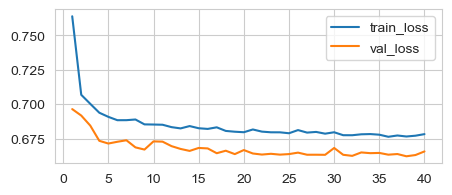

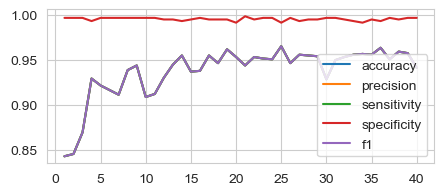

ValueError: multiclass format is not supported

In [20]:
plt.figure(figsize=(5, 2))
plt.plot(epochs, train_losses_epoch, label='train_loss')
plt.plot(epochs, val_losses_epoch, label='val_loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
print(pd.DataFrame(conf_matrix))

     0    1    2
0  561    2    0
1   61  376    4
2    1    1  163


In [22]:
pred_summary[pred_summary["correct"] == False]

,label,prediction,barcode,correct
2,1,0,LC499_AAAGGGCCAAATGCTC,False
4,1,0,LC499_AACAAAGTCCATGACA,False
20,1,0,LC499_ACAGGCCAGCATTGGG,False
38,1,0,LC499_AGACAAAAGAAATACC,False
39,1,0,LC499_AGATAGAGTGTACGCC,False
...,...,...,...,...
924,1,2,LC676_merged_hg38.sc_CTTGAAGCATCCATAG,False
948,1,2,LC676_merged_hg38.sc_GCTTTCGAGACGACTG,False
968,1,2,LC676_merged_hg38.sc_TAGGAGGTCAACTTGG,False
1037,2,0,LC677_merged_hg38.sc_CAATCCCGTAAGGTCG,False


In [27]:
#torch.save(model.state_dict(), "model_dec20_2_multi.pt")

### Evaluate performance

In [18]:
model.load_state_dict(torch.load("model_dec20_2_multi.pt"))
model.to("mps")

CNN(
  (conv_f2_l1): Conv2d(1, 8, kernel_size=(5, 45), stride=(1, 11), padding=(0, 2))
  (conv_f2_l2): Conv2d(8, 16, kernel_size=(1, 45), stride=(1, 4))
  (bn_f2_l1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_f2_l2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_fc_l1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool_f2_l1): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool_f2_l2): MaxPool2d(kernel_size=(1, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc_l1): Linear(in_features=223, out_features=64, bias=True)
  (fc_l2): Linear(in_features=64, out_features=3, bias=True)
  (dropout_f2): Dropout(p=0.5, inplace=False)
  (dropout_fc): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=1)
)

In [19]:
val_labels = []
val_predictions = []
val_directories = []

model.eval()
with torch.no_grad():
        for x2, y0, bcs, coord in val_dataloader:
            x2 = x2.float().to("mps")
            y0 = y0.float().to("mps")

            yh = model(x2, coord)

            loss = criterion(yh, y0)
            
            yp_am = torch.argmax(yh, dim=1).to("cpu").numpy().tolist()
            y0_am = torch.argmax(y0, dim=1).to("cpu").numpy().tolist()

            val_labels = val_labels + y0_am
            val_predictions = val_predictions + yp_am
            val_directories = val_directories + list(bcs)

        pred_summary = pd.DataFrame(
            {"label": val_labels, "prediction": val_predictions, "barcode": val_directories})
        pred_summary["correct"] = pred_summary["label"] == pred_summary["prediction"]

        conf_matrix = confusion_matrix(pred_summary["label"], pred_summary["prediction"])
        tp, tn, fp, fn = conf_matrix[1, 1], conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0]

In [20]:
conf_matrix

array([[561,   2],
       [ 61, 249]])

In [21]:
accuracy = accuracy_score(pred_summary["label"], pred_summary["prediction"])
precision = precision_score(pred_summary["label"], pred_summary["prediction"])
recall = recall_score(pred_summary["label"], pred_summary["prediction"])
specificity = tn / (tn + fp)

In [22]:
accuracy, precision, recall, specificity

(0.9278350515463918,
 0.9920318725099602,
 0.8032258064516129,
 0.9964476021314387)